In [1]:
%matplotlib widget

import os
import sys

sys.path.insert(0, os.getenv("HOME") + "/pycode/MscThesis/")
# sys.path.insert(0,r'C:\Users\coren\Documents\PhD\Code\AMFtrack')

import pandas as pd
from amftrack.util.sys import (
    get_dates_datetime,
    get_dirname,
    temp_path,
    get_data_info,
    update_plate_info,
    get_current_folders,
    get_folders_by_plate_id,
)


import ast
from amftrack.plotutil import plot_t_tp1
from scipy import sparse
from datetime import datetime
import pickle
import scipy.io as sio
from pymatreader import read_mat
from matplotlib import colors
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import frangi
from skimage import filters
from random import choice
import scipy.sparse
import os
from amftrack.pipeline.functions.image_processing.extract_graph import (
    from_sparse_to_graph,
    generate_nx_graph,
    sparse_to_doc,
)
from skimage.feature import hessian_matrix_det
from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Experiment,
)
from amftrack.pipeline.paths.directory import (
    run_parallel,
    find_state,
    directory_scratch,
    directory_project,
    run_parallel_stitch,
)
from labelbox import Project, Dataset, Client
import os
from amftrack.transfer.functions.transfer import upload, zip_file
from labelbox.schema.ontology import OntologyBuilder, Tool, Classification, Option
from labelbox import Client, LabelingFrontend, LabelImport, MALPredictionImport
from labelbox.data.annotation_types import (
    Label,
    ImageData,
    ObjectAnnotation,
    MaskData,
    Rectangle,
    Point,
    Line,
    Mask,
    Polygon,
    Radio,
    Checklist,
    Text,
    ClassificationAnnotation,
    ClassificationAnswer,
)
from labelbox.data.serialization import NDJsonConverter
import uuid
import json
import numpy as np
from amftrack.pipeline.functions.image_processing.extract_skel import (
    extract_skel_tip_ext,
)

/home/cbisot/pycode/MscThesis/amftrack/transfer/functions/transfer.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
API_KEY = os.getenv("LABELBOX_API_KEY")
client = Client(api_key=API_KEY)
API = "sl.BECKwhlErTK7i6YvhidUIP67xxjFeapzLiH_rjbACF82C9815xa0TzGyyWoSU_sEbBUSaOHTukY0fomrl0GGyryoH_xwu0roBjULtg3ccvWOV0hbJe7dQ2rBNcUvWNHBe3_I9D4pB5w"
np.save(os.getenv("HOME") + "/pycode/API_drop.npy", API)
API = str(np.load(os.getenv("HOME") + "/pycode/API_drop.npy"))
dir_drop = "labelbox"

In [3]:
project = client.create_project(name="fungi3")
dataset = client.create_dataset(name="network_old3")
ontology_builder = OntologyBuilder(
    tools=[Tool(tool=Tool.Type.SEGMENTATION, name="mask")]
)
editor = next(client.get_labeling_frontends(where=LabelingFrontend.name == "Editor"))

project.setup(editor, ontology_builder.asdict())
project.datasets.connect(dataset)

In [4]:
def signing_function(obj_bytes: bytes) -> str:
    url = client.upload_data(content=obj_bytes, sign=True)
    return url


def create_line(edge, graph):
    data = graph.get_edge_data(*edge)["pixel_list"]
    line = Line(points=[Point(x=pixel[1], y=pixel[0]) for pixel in data])
    line_annotation = ObjectAnnotation(value=line, name="Line")
    return line_annotation


def create_mask(dilated):
    mask_data = MaskData.from_2D_arr(arr=dilated.astype(np.uint8))
    mask = Mask(mask=mask_data, color=(0, 0, 0))
    mask_annotation = ObjectAnnotation(value=mask, name="mask")
    return mask_annotation

In [5]:
directory = directory_project
all_folders = get_current_folders(directory)
folders = all_folders.loc[all_folders["Plate"] == "94"]

In [6]:
i = 80
folder_list = list(folders["folder"])
folder_list.sort()
directory_name = folder_list[i]
path_snap = directory + directory_name
path_tile = path_snap + "/Img/TileConfiguration.txt.registered"
try:
    tileconfig = pd.read_table(
        path_tile,
        sep=";",
        skiprows=4,
        header=None,
        converters={2: ast.literal_eval},
        skipinitialspace=True,
    )
except:
    print("error_name")
    path_tile = path_snap + "/Img/TileConfiguration.registered.txt"
    tileconfig = pd.read_table(
        path_tile,
        sep=";",
        skiprows=4,
        header=None,
        converters={2: ast.literal_eval},
        skipinitialspace=True,
    )

In [9]:
import dropbox as dbx

timeout = 900
low = 30
high = 80
dist = 30
for j in range(len(tileconfig[0])):
    name = tileconfig[0][j]
    imname = "/Img/" + name.split("/")[-1]
    path = directory + directory_name + imname
    im = imageio.imread(directory + directory_name + imname)
    id_unique = (directory_name + name.split("/")[-1]).split(".")[0] + ".png"
    # path_save = f'{os.getenv("TEMP")}'+id_unique
    # imageio.imsave(path_save,im)
    # upload(API,path_save,f'/{dir_drop}/{id_unique}',chunk_size=256 * 1024 * 1024)
    # os.remove(path_save)
    drop = dbx.Dropbox(API, timeout=timeout)
    metadata = drop.sharing_create_shared_link(f"/{dir_drop}/{id_unique}")
    path = "?".join([metadata.url.split("?")[0], "raw=1"])
    data_row = dataset.create_data_row(row_data=path)
    segmented = extract_skel_tip_ext(im, low, high, dist)
    # skeletonized = cv2.ximgproc.thinning(np.array(255*(segmented>0),dtype=np.uint8))
    # nx_g,pos = generate_nx_graph(from_sparse_to_graph(scipy.sparse.dok_matrix(skeletonized)))
    annotations = [create_mask(segmented)]
    image_data = ImageData(uid=data_row.uid)

    mal_label = Label(data=image_data, annotations=annotations)
    mal_label.assign_feature_schema_ids(ontology_builder.from_project(project))
    ndjson_labels = list(NDJsonConverter.serialize([mal_label]))
    upload_job = MALPredictionImport.create_from_objects(
        client=client,
        project_id=project.uid,
        name=f"upload_label_import_job{int(datetime.now().timestamp())}",
        predictions=ndjson_labels,
    )

KeyboardInterrupt: 

In [22]:
create_mask(segmented)

In [100]:
j = 42
name = tileconfig[0][j]
imname = "/Img/" + name.split("/")[-1]
path = directory + directory_name + imname
im = imageio.imread(directory + directory_name + imname)

In [101]:
id_unique = (directory_name + name.split("/")[-1]).split(".")[0] + ".png"
path_save = f'{os.getenv("TEMP")}' + id_unique
imageio.imsave(path_save, im)
upload(API, path_save, f"/{dir_drop}/{id_unique}", chunk_size=256 * 1024 * 1024)
os.remove(path_save)
drop = dbx.Dropbox(API, timeout=timeout)
metadata = drop.sharing_create_shared_link(f"/{dir_drop}/{id_unique}")
path = "?".join([metadata.url.split("?")[0], "raw=1"])
data_row = dataset.create_data_row(row_data=path)

In [102]:
def signing_function(obj_bytes: bytes) -> str:
    url = client.upload_data(content=obj_bytes, sign=True)
    return url


# mal_label = Label(
#     data=image_data,
#     annotations = [line_annotation
#     ]
# )

# label.add_url_to_masks(signing_function)

# mal_label.assign_feature_schema_ids(ontology_builder.from_project(project))

# ndjson_labels = list(NDJsonConverter.serialize([mal_label]))
# upload_job = MALPredictionImport.create_from_objects(
#     client = client,
#     project_id = project.uid,
#     name="upload_label_import_job2",
#     predictions=ndjson_labels)

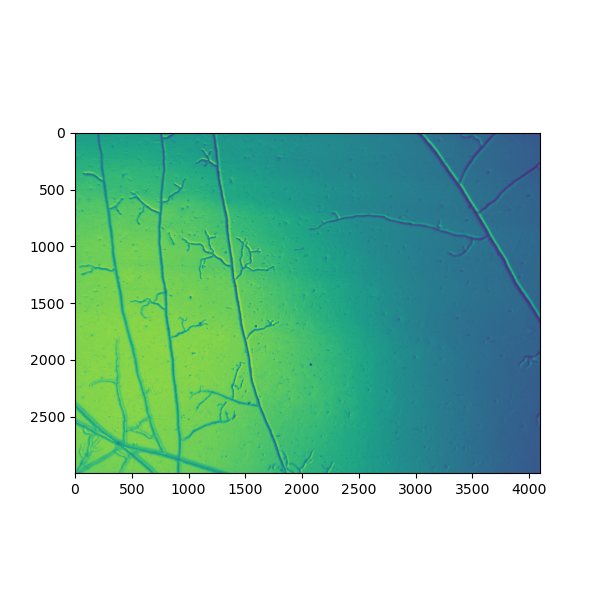

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(im)

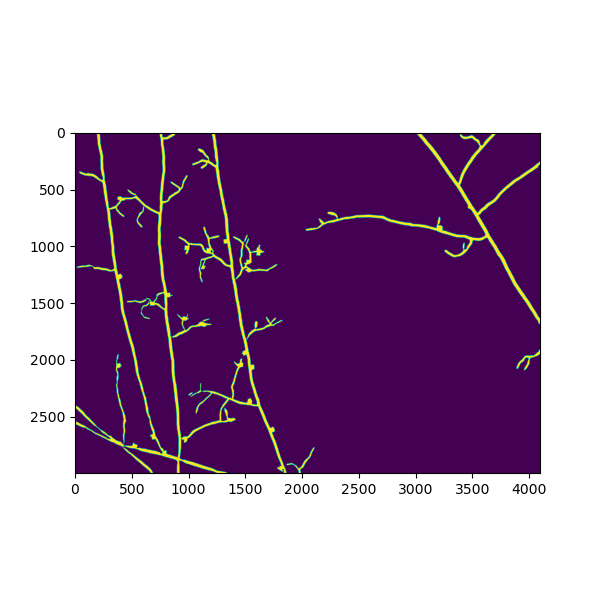

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(segmented)

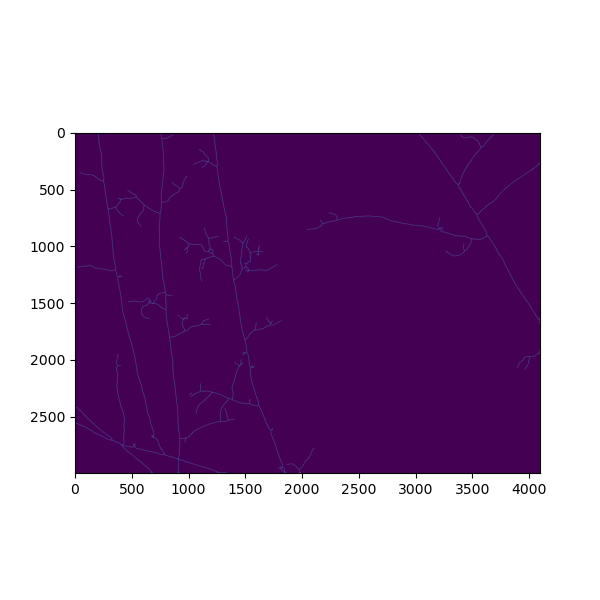

In [76]:
skeletonized = cv2.ximgproc.thinning(np.array(255 * (segmented > 0), dtype=np.uint8))
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(skeletonized)

In [91]:
def create_line(edge, graph):
    data = graph.get_edge_data(*edge)["pixel_list"]
    line = Line(points=[Point(x=pixel[0], y=pixel[1]) for pixel in data])
    line_annotation = ObjectAnnotation(value=line, name="Line")
    return line_annotation

In [103]:
list_lines = [create_line(edge, nx_g) for edge in nx_g.edges]

In [104]:
list_lines

[ObjectAnnotation(name='Line', feature_schema_id=None, extra={}, value=Line(extra={}, points=[Point(extra={}, x=0.0, y=192.0), Point(extra={}, x=0.0, y=193.0), Point(extra={}, x=0.0, y=194.0), Point(extra={}, x=0.0, y=195.0), Point(extra={}, x=0.0, y=196.0), Point(extra={}, x=0.0, y=197.0), Point(extra={}, x=0.0, y=198.0), Point(extra={}, x=0.0, y=199.0), Point(extra={}, x=0.0, y=200.0), Point(extra={}, x=0.0, y=201.0), Point(extra={}, x=0.0, y=202.0), Point(extra={}, x=0.0, y=203.0), Point(extra={}, x=0.0, y=204.0), Point(extra={}, x=0.0, y=205.0)]), classifications=[]),
 ObjectAnnotation(name='Line', feature_schema_id=None, extra={}, value=Line(extra={}, points=[Point(extra={}, x=0.0, y=205.0), Point(extra={}, x=1.0, y=205.0), Point(extra={}, x=2.0, y=205.0), Point(extra={}, x=3.0, y=205.0), Point(extra={}, x=4.0, y=205.0), Point(extra={}, x=5.0, y=205.0), Point(extra={}, x=6.0, y=205.0), Point(extra={}, x=7.0, y=205.0), Point(extra={}, x=8.0, y=205.0), Point(extra={}, x=9.0, y=205.0

In [105]:
image_data = ImageData(uid=data_row.uid)
label = Label(data=image_data, annotations=list_lines)

In [108]:
mal_label = Label(data=image_data, annotations=list_lines)

label.add_url_to_masks(signing_function)

mal_label.assign_feature_schema_ids(ontology_builder.from_project(project))

ndjson_labels = list(NDJsonConverter.serialize([mal_label]))
upload_job = MALPredictionImport.create_from_objects(
    client=client,
    project_id=project.uid,
    name="upload_label_import_job4",
    predictions=ndjson_labels,
)